# TO DO

- Ajouter la baseline débile de la couleur majoritaire dans le dataset de training au dictionnaire des baseline
- Controler que les inputs des fonctions et les imports de packages ne sont pas déclarés en local
- Packager les calculs de baseline (classe baseline et fonctions pour les différentes baselines)
- Prevoir de la dataviz sur le sujet

**optionnel :**
- Basculer sur sklearn pour voir si plus rapide
- Essayer de faire une baseline sur la transformée de Fourrier (pas prioritaire)

# Import

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Input, Conv2D, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import to_categorical
import datetime
import pandas as pd

In [74]:
from neuralart.data import *

In [75]:
# Movement selection

merge_mov_1={'abstract_expressionism': 'abstract',
                 'action_painting': 'abstract',
                 'analytical_cubism': 'cubism',
                 'art_nouveau_modern': None,
                 'baroque': None,
                 'color_field_painting': 'color_field_painting',
                 'contemporary_realism': None,
                 'cubism': 'cubism',
                 'early_renaissance': 'renaissance',
                 'expressionism': 'expressionism',
                 'fauvism': None,
                 'high_renaissance': 'renaissance',
                 'impressionism': 'impressionism',
                 'mannerism_late_renaissance': None,
                 'minimalism': None,
                 'naive_art_primitivism': None,
                 'new_realism': None,
                 'northern_renaissance': 'renaissance',
                 'pointillism': None,
                 'pop_art': None,
                 'post_impressionism': None,
                 'realism': 'realism',
                 'rococo': None,
                 'romanticism': 'romanticism',
                 'symbolism': None,
                 'synthetic_cubism': 'cubism',
                 'ukiyo_e': None}


In [76]:

MAIN_PATH = "../raw_data/wikiart/" # Path to the directory which contains CSVs and the folder 'dataset'
IMAGES = "dataset"
CSV_NAME = "wikiart-movement-genre_True-class_8-merge_mov-1-n_1000_max.csv" # Nwikiart-movement-genre_True-class_3-merge_test1-n_1000_max.csvme of the CSV we want to use
NUM_MOVEMENT = 8 # Number of movements to classify
NUM_GENRE = 10 # Number of genres to classify
IMG_HEIGHT = IMG_WIDTH = 224 # Model's inputs shapes

USER = "gregoire" # Choose between 'common', 'pablo', 'quentin', 'gregoire', 'alex'
MODEL_NAME = "Custom v1" # Set the name of the model 

'''----------------------------------
Load the CSV
----------------------------------'''
BATCH_SIZE = 32
EPOCHS = 50


'''----------------------------------
Load the CSV
----------------------------------'''
raw_df = pd.read_csv(MAIN_PATH + CSV_NAME)
df = raw_df.iloc[:, 0:3]
assert type(df) == type(pd.DataFrame()) # Check if we created a dataframe
assert df.iloc[:, 1].nunique() ==  NUM_MOVEMENT # Check if we have the correct number of movements
assert df.iloc[:, 2].nunique() ==  NUM_GENRE # Check if we have the correct number of genres

print(f"Number of images : {df.shape[0]}")

'''----------------------------------
OHE
----------------------------------'''

df_genre_ohe = pd.get_dummies(df['genre'])
df_mov_ohe = pd.get_dummies(df['movement'])

df = pd.concat([df,df_genre_ohe, df_mov_ohe], axis=1)


Number of images : 8000


In [77]:
df.head()

,file_name,movement,genre,abstract_painting,cityscape,genre_painting,illustration,landscape,nude_painting,portrait,...,sketch_and_study,still_life,abstract,color_field_painting,cubism,expressionism,impressionism,realism,renaissance,romanticism
0,abstract-expressionism_esteban-vicente_copla-1...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,abstract-expressionism_sam-francis_untitled-sf...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,abstract-expressionism_brice-marden_cyprian-ev...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,abstract-expressionism_audrey-flack_still-life...,abstract,still_life,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,action-painting_jackson-pollock_black-white-nu...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [82]:
'''----------------------------------
Train, test, val split
----------------------------------'''
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
# assert type(df_train) == type(pd.DataFrame()) # Check if we created dataframes
# assert type(df_test) == type(pd.DataFrame())
# assert type(df_val) == type(pd.DataFrame())

print(f"Number of images in train set : {df_train.shape[0]}")
print(f"Number of images in val set : {df_val.shape[0]}")
print(f"Number of images in test set : {df_test.shape[0]}")
print('\n')

'''----------------------------------
Baselines
----------------------------------'''

#baseline calculated on occurence in train set 
baseline_mov=dict(df_train.groupby(by='movement')['file_name'].count()/df_train.shape[0])
baseline_gen=dict(df_train.groupby(by='genre')['file_name'].count()/df_train.shape[0])

assert sum(baseline_mov.values())==1
assert sum(baseline_gen.values())==1


Number of images in train set : 5120
Number of images in val set : 1280
Number of images in test set : 1600




In [79]:
'''----------------------------------
Setup outputs columns
----------------------------------'''
#assert len(list(df.columns[1:])) == 2 # Check if we have two outputs columns
#columns=list(df.columns[1:])

columns_genre = list(df_genre_ohe.columns)
columns_mov = list(df_mov_ohe.columns)
columns = columns_mov + columns_genre 

'''----------------------------------
Train ImageDataGenerator
----------------------------------'''
train_datagen = ImageDataGenerator( # This generator is only used to train data because it has data augmentation and we do not want to augment data from the test or val set
    rescale=1./255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    dtype=tf.float32
    )

#assert type(train_datagen) == type(ImageDataGenerator())

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, # Dataset used to get the path (column filename) and the linked outputs
    directory=MAIN_PATH + IMAGES, # Path to the images
    x_col="file_name", # Column with the name of the images that the generator will get from the directory
    y_col=columns, # Columns with the output of the images that the generator will get from the csv
    batch_size=BATCH_SIZE,
    seed=None,
    shuffle=True,
    class_mode="raw", # numpy array of values in y_col columns
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize the images to the input shape of the model
    data_format='channels_last'
    ) 


'''----------------------------------
Test and Val ImageDataGenerator
----------------------------------'''
test_val_datagen = ImageDataGenerator(  # We use a new generator without data augmentation
    rescale=1./255
    )

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=MAIN_PATH + IMAGES,
    x_col="file_name",
    y_col=columns,
    batch_size=BATCH_SIZE,
    seed=None,
    shuffle=False,
    class_mode="raw", 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    data_format='channels_last'
    )

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=MAIN_PATH + IMAGES,
    x_col="file_name",
    batch_size=1,
    seed=None,
    shuffle=False,
    class_mode=None, # No targets are returned (the generator will only yield batches of image data, which is useful to use in model.predict()
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    data_format='channels_last'
    )


#assert type(test_val_datagen) == type(ImageDataGenerator())

Found 5120 validated image filenames.
Found 1280 validated image filenames.
Found 1600 validated image filenames.


# Baseline Functions

In [83]:
root=MAIN_PATH + IMAGES + '/'
n_colors=5

## Occurence Baseline

In [84]:
baseline_mov=dict(df_train.groupby(by='movement')['file_name'].count()/df_train.shape[0])
baseline_mov

{'abstract': 0.12265625,
 'color_field_painting': 0.119921875,
 'cubism': 0.1271484375,
 'expressionism': 0.1259765625,
 'impressionism': 0.1263671875,
 'realism': 0.1275390625,
 'renaissance': 0.125,
 'romanticism': 0.125390625}

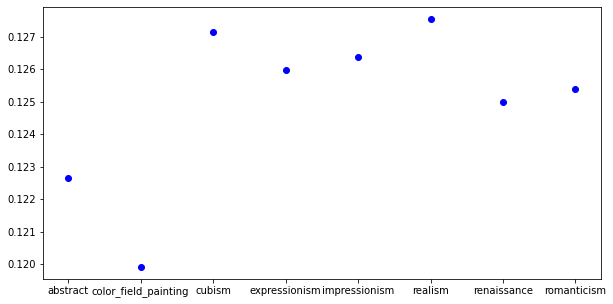

In [85]:
import matplotlib.pyplot as plt
mov_bas=pd.DataFrame(df_train.groupby(by='movement')['file_name'].count()/df_train.shape[0]).reset_index()
plt.figure(figsize=(10, 5))
plt.scatter(x=mov_bas['movement'],y=mov_bas['file_name'],c='b');

In [86]:
baseline_gnd=dict(df_train.groupby(by='genre')['file_name'].count()/df_train.shape[0])
baseline_gnd

{'abstract_painting': 0.2458984375,
 'cityscape': 0.054296875,
 'genre_painting': 0.115234375,
 'illustration': 0.01953125,
 'landscape': 0.1416015625,
 'nude_painting': 0.026171875,
 'portrait': 0.1859375,
 'religious_painting': 0.098046875,
 'sketch_and_study': 0.0525390625,
 'still_life': 0.0607421875}

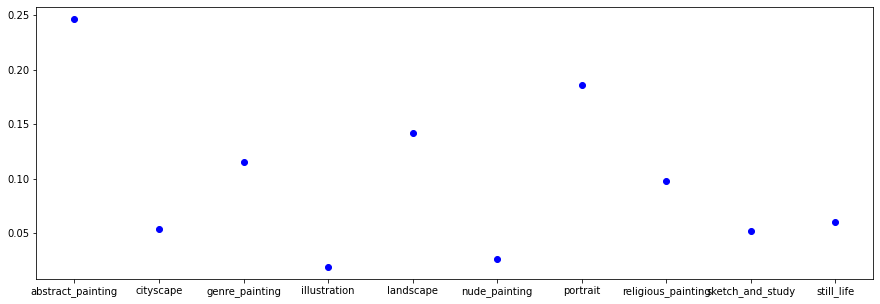

In [87]:
mov_bas=pd.DataFrame(df_train.groupby(by='genre')['file_name'].count()/df_train.shape[0]).reset_index()
plt.figure(figsize=(15, 5))
plt.scatter(x=mov_bas['genre'],y=mov_bas['file_name'],c='b');

## Average and dominant color baseline

### General Fourier Functions

In [124]:
#functions for Fourier Transformation
import numpy
from numpy.fft import fft2, fftshift


def matriceImage(matrice,gamma,rgb):
    s = matrice.shape
    a=1.0/gamma;
    norm=matrice.max()
    m = np.power(matrice/norm,a)
    im = np.zeros((s[0],s[1],3),dtype=float)
    im[:,:,0] = rgb[0]*m
    im[:,:,1] = rgb[1]*m
    im[:,:,2] = rgb[2]*m
    return im

def matriceImageLog(matrice,rgb):
    s = matrice.shape
    m = np.log10(1+matrice)
    min = m.min()
    max = m.max()
    m = (m-min)/(max-min)
    im = numpy.zeros((s[0],s[1],3),dtype=float)
    im[:,:,0] = rgb[0]*m
    im[:,:,1] = rgb[1]*m
    im[:,:,2] = rgb[2]*m
    return im

def plotSpectre(image,Lx,Ly):
    (Ny,Nx,p) = image.shape
    fxm = Nx*1.0/(2*Lx)
    fym = Ny*1.0/(2*Ly)
    plt.imshow(image,extent=[-fxm,fxm,-fym,fym])
    
    plt.xlabel("fx")
    plt.ylabel("fy")

### Function for one image

In [89]:
#Fonction pour une image

def baselines_viz_single(img,n_colors = 5,plot=True,array=True,rgb_fft='g'):

    import cv2 # requires pip install opencv-python

    #resize and flatten
    img_224=np.array(tf.image.resize(img,[224,224]))
    img_pixel = np.float32(img_224.reshape(-1, 3))

    #average color
    avg_color=img_pixel.mean(axis=0)
    img_pixel.shape  

    #Recherche palette dominante et couleur dominante par méthode des kmoyens (sur 5 couleurs par défaut)
    pixels=np.float32(img_pixel)


    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, .5)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    dom_color = palette[np.argmax(counts)]

    
    #Magnitude Spectrum
    
    rgb_dict={'r':0,'g':1,'b':2}
    
    U=numpy.array(img_224[:,:,rgb_dict[rgb_fft]],dtype=np.float64)
    V=np.fft.fft2(U)
    VC = np.fft.fftshift(V)
    P = np.power(numpy.abs(VC),2)
    img_tff = matriceImageLog(P,[1,0,0])

    
    
    #Viz functions
    avg_patch = np.ones(shape=(224,224,3), dtype=np.uint8)*np.uint8(avg_color)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(224*freqs)

    dom_patch = np.zeros(shape=(224,224,3), dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(16,10))
    ax0.imshow(img)
    ax0.set_title('Original Image')
    ax0.axis('off')
    ax1.imshow(np.array(img_224,dtype=int))
    ax1.set_title('Resized Image')
    ax1.axis('off')
    ax2.imshow(avg_patch)
    ax2.set_title('Average color')
    ax2.axis('off')
    ax3.imshow(dom_patch)
    ax3.set_title('Dominant colors')
    ax3.axis('off')
    ax4.imshow(img_tff)
    ax4.set_title('Magnitude Spectrum')
    ax4.axis('off')
    
    #output selection
    
    if plot :
        plt.show(fig)
    
    weights=counts/pixels.shape[0]
    out=None
    if array: 

        img_dict={}
        img_dict['avg_color']=avg_color
        img_dict['dom_color']=palette
        img_dict['dom_weights']=weights
        img_dict['magnitude_spectrum']=img_tff
    
    return img_dict

In [90]:
test=df_train['file_name'].sample(6)
test

6309    northern-renaissance_lucas-cranach-the-elder_p...
4055       impressionism_childe-hassam_a-country-road.jpg
3983    expressionism_amedeo-modigliani_woman-with-a-r...
6516    northern-renaissance_albrecht-durer_hohenasper...
3557    expressionism_edvard-munch_walter-rathenau-190...
2624    cubism_marc-chagall_the-feast-of-the-tabernacl...
Name: file_name, dtype: object

In [91]:
paintings_sample=['expressionism_jean-paul-lemieux_jeune-fille-au-chandail-rouge-1974.jpg',
'expressionism_ernst-ludwig-kirchner_mountains-and-houses-in-the-snow.jpg',
'expressionism_oskar-kokoschka_not_detected_235840.jpg',
'impressionism_pierre-auguste-renoir_head-of-a-woman-1913.jpg',
'abstract-expressionism_esteban-vicente_orange-red-black-1962.jpg',
'northern-renaissance_hans-holbein-the-younger_studies-of-the-hands-of-erasmus-of-rotterdam.jpg',
'impressionism_edmund-charles-tarbell_profile-1900.jpg',
'cubism_pablo-picasso_portrait-of-manuel-pallares-1909.jpg']

In [92]:
test_img1=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[0])
test_img2=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[1])
test_img3=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[2])
test_img4=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[3])
test_img5=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[4])
test_img6=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[5])
test_img7=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[6])
test_img8=plt.imread(MAIN_PATH+IMAGES+'/'+paintings_sample[7])

In [126]:
test_img1.shape

(603, 325, 3)

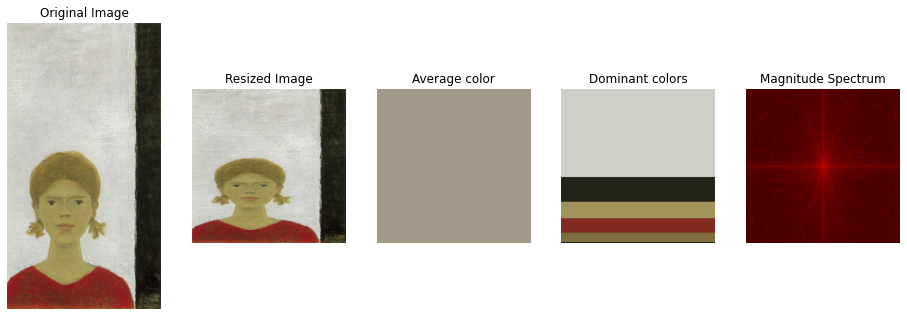

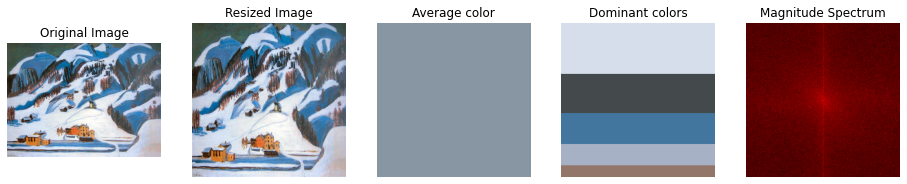

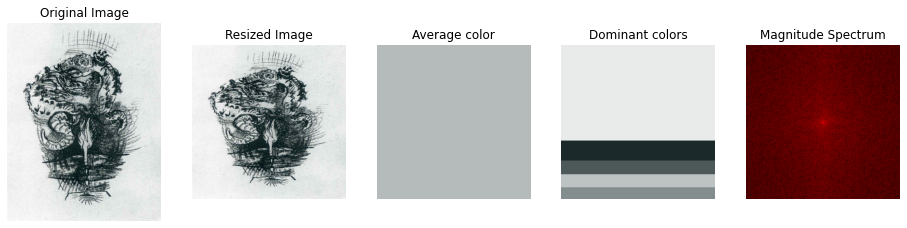

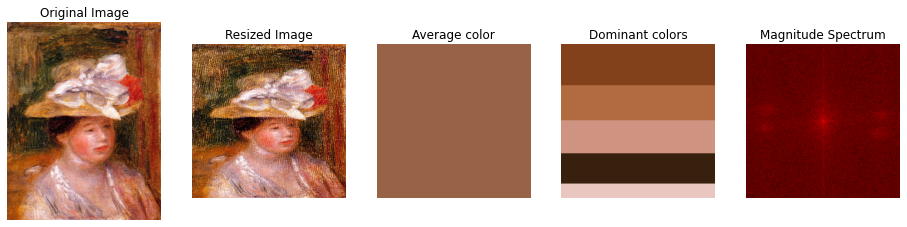

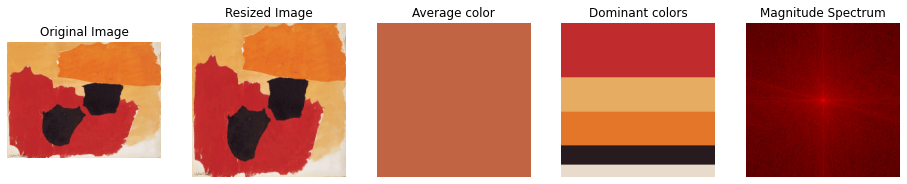

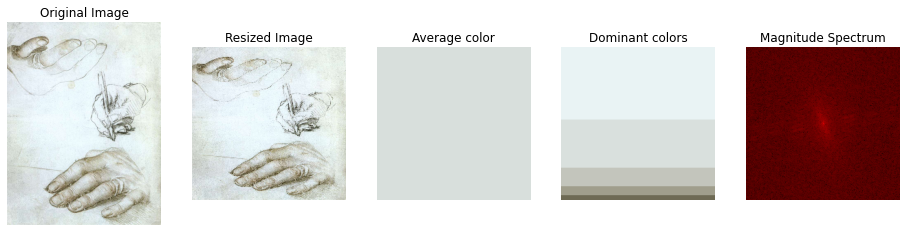

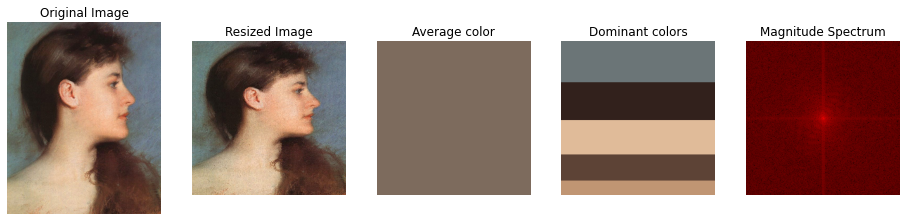

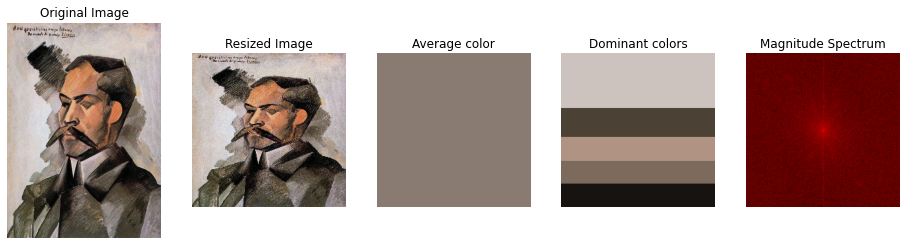

In [93]:
img1_col=baselines_viz_single(test_img1,array=True)
img2_col=baselines_viz_single(test_img2,array=True)
img3_col=baselines_viz_single(test_img3,array=True)
img4_col=baselines_viz_single(test_img4,array=True)
img5_col=baselines_viz_single(test_img5,array=True)
img6_col=baselines_viz_single(test_img6,array=True)
img7_col=baselines_viz_single(test_img7,array=True)
img7_col=baselines_viz_single(test_img8,array=True)

### Function for a dataset of images or a movement

In [94]:

def baselines_viz_mov(df,root,mov,n_colors = 5,plot=True,array=True,rgb_fft='g'):

    '''
    df : DataFrame ; initial dataframe with filename and movement
    mov : String ; chosen movement for baseline observation
    plot : Bool ; chose to print the colors when executing the function
    plot : Bool ; returns the arrays for colors : (avg_color,palette)
    
    '''
    
    path_list=df['file_name'][df['movement']==mov]
    pixels=np.empty(3)
    fourier_img=np.zeros((224,224, 3))
    for file in list(path_list):
        #average and dominant colors :
        #images are reshaped to 224X224 and pixels are stacked next to each other
        path=root+file
        img=plt.imread(path)
        img_224=np.array(tf.image.resize(img,[224,224]))
        img_pixel = np.float32(img_224.reshape(-1, 3))
        pixels=np.vstack((pixels,img_pixel))
        
        #Fourier transfo : average value for each image inside the movement
        #f = np.fft.fft2(img_224,)
        #fshift = np.fft.fftshift(f)
        #np.seterr(divide = 'ignore') 
        #fourier_img += 75*np.log(np.abs(fshift))
        #np.seterr(divide = 'warn')

            #Magnitude Spectrum
    
        rgb_dict={'r':0,'g':1,'b':2}
    
        U=numpy.array(img_224[:,:,rgb_dict[rgb_fft]],dtype=np.float64)
        V=np.fft.fft2(U)
        VC = np.fft.fftshift(V)
        P = np.power(numpy.abs(VC),2)
        img_tff = matriceImageLog(P,[1,0,0])
        fourier_img += img_tff
        
    avg_color=pixels.mean(axis=0)


    #Recherche palette dominante et couleur dominante par méthode des kmoyens (sur 5 couleurs par défaut)
    #premier pixel était là pour initialiser, il faut le virer
    pixels=np.float32(pixels)[1:]

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, .5)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    dom_color = palette[np.argmax(counts)]

        ##Magnitude Spectrum

    magnitude_spectrum = fourier_img/len(path_list)
        
        #Viz functions
    avg_patch = np.ones(shape=(224,224,3), dtype=np.uint8)*np.uint8(avg_color)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(224*freqs)

    dom_patch = np.zeros(shape=(224,224,3), dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
        
        
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,10))
    ax0.imshow(avg_patch)
    ax0.set_title(mov.capitalize()+' - Average color')
    ax0.axis('off')
    ax1.imshow(dom_patch)
    ax1.set_title(mov.capitalize()+' - Dominant colors')
    ax1.axis('off')
    ax2.imshow(magnitude_spectrum, cmap = 'gray')
    ax2.set_title('Magnitude Spectrum')
    ax2.axis('off')
    plt.show(fig)

    #output selection
    
    if plot :
        plt.show(fig)
    

    weights=counts/pixels.shape[0]
    out=None
    if array: 
        out =(avg_color,palette,weights,magnitude_spectrum)
    
    return out
    

##### Test on a specific movement : expressionism

In [95]:
mov_test='expressionism'
test2=df_train[df_train['movement']==mov_test]['file_name'][0:6]
test2

3840    expressionism_jacoba-van-heemskerck_forest-tra...
3624     expressionism_vilmos-aba-novak_carousel-1931.jpg
3830    expressionism_zinaida-serebriakova_portrait-of...
3777    expressionism_henri-matisse_reader-on-a-black-...
3495               expressionism_arthur-segal_eliyahu.jpg
3675    expressionism_wassily-kandinsky_a-mountain-190...
Name: file_name, dtype: object

In [96]:
test2_img1=plt.imread(MAIN_PATH+IMAGES+'/'+test2[test2.index[0]])
test2_img2=plt.imread(MAIN_PATH+IMAGES+'/'+test2[test2.index[1]])
test2_img3=plt.imread(MAIN_PATH+IMAGES+'/'+test2[test2.index[2]])
test2_img4=plt.imread(MAIN_PATH+IMAGES+'/'+test2[test2.index[3]])
test2_img5=plt.imread(MAIN_PATH+IMAGES+'/'+test2[test2.index[4]])
test2_img6=plt.imread(MAIN_PATH+IMAGES+'/'+test2[test2.index[5]])


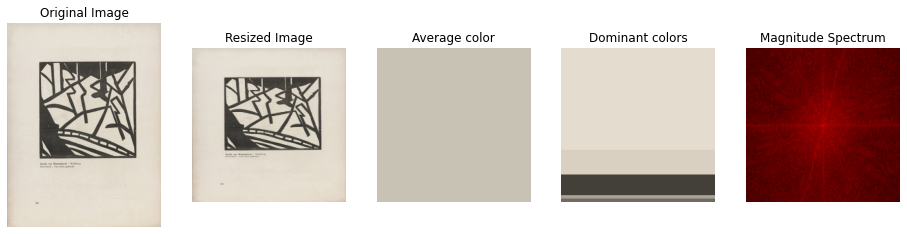

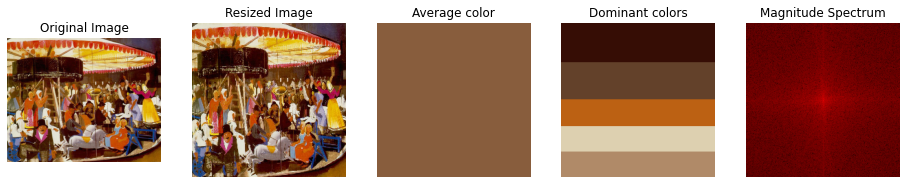

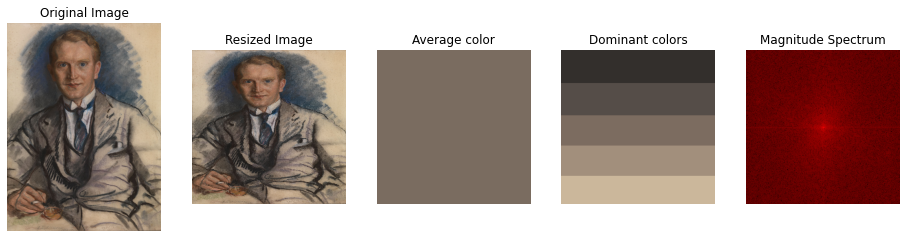

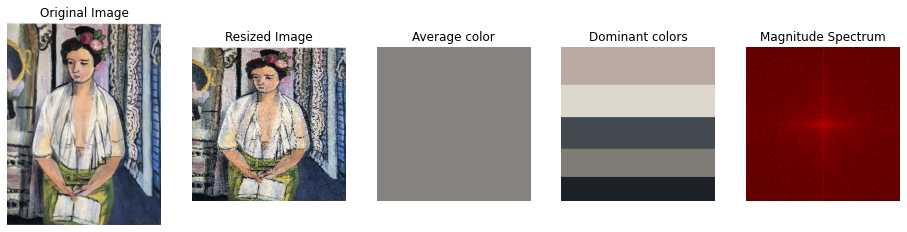

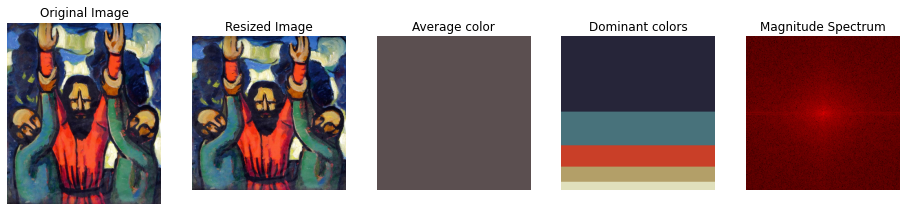

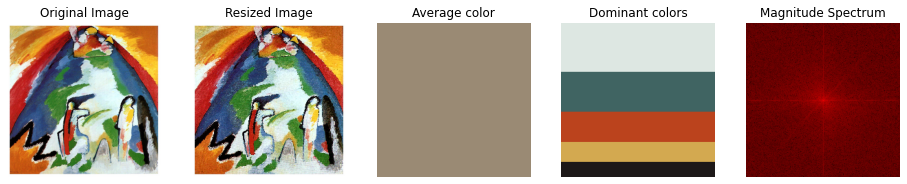

In [97]:
img1_col=baselines_viz_single(test2_img1,array=True)
img2_col=baselines_viz_single(test2_img2,array=True)
img3_col=baselines_viz_single(test2_img3,array=True)
img4_col=baselines_viz_single(test2_img4,array=True)
img5_col=baselines_viz_single(test2_img5,array=True)
img6_col=baselines_viz_single(test2_img6,array=True)

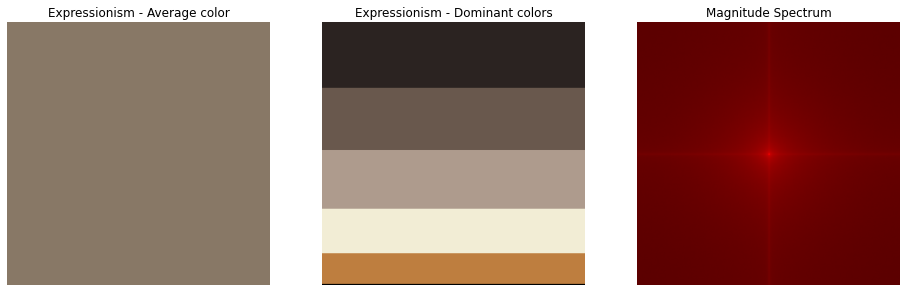

(array([136.98235363, 120.34178132, 102.6577894 ]),
 array([[174.56169 , 155.5234  , 141.46861 ],
        [105.032616,  88.73239 ,  77.35399 ],
        [ 43.67706 ,  35.707188,  33.47822 ],
        [242.78644 , 237.80115 , 213.3333  ],
        [190.32677 , 126.80766 ,  63.47853 ]], dtype=float32),
 array([0.22312638, 0.23731124, 0.2500902 , 0.1727506 , 0.11672158]),
 array([[[0.33584506, 0.        , 0.        ],
         [0.36198935, 0.        , 0.        ],
         [0.36302254, 0.        , 0.        ],
         ...,
         [0.36199784, 0.        , 0.        ],
         [0.36302254, 0.        , 0.        ],
         [0.36198935, 0.        , 0.        ]],
 
        [[0.35906544, 0.        , 0.        ],
         [0.36250925, 0.        , 0.        ],
         [0.36023887, 0.        , 0.        ],
         ...,
         [0.36048371, 0.        , 0.        ],
         [0.3622628 , 0.        , 0.        ],
         [0.362063  , 0.        , 0.        ]],
 
        [[0.35830572, 0.        ,

In [99]:
baseline_expressionism=baselines_viz_mov(df,root,'expressionism',5)
baseline_expressionism

**Create baseline dict**

In [100]:
#function to calculate baseline dictionnary of colors

root=MAIN_PATH + IMAGES + '/'

def baseline_dict(df,root,n_colors=5):

    mov_list=list(df['movement'].unique())
    base_dict={}
    for mov in mov_list:
        mov_dict={}
        baseline=baselines_viz_mov(df,root,mov,n_colors,plot=False,array=True)
        mov_dict['avg_color']=baseline[0]
        mov_dict['dom_color']=baseline[1]
        mov_dict['dom_weights']=baseline[2]
        mov_dict['mov_fft']=baseline[3]
        base_dict[mov]=mov_dict
    
    return base_dict

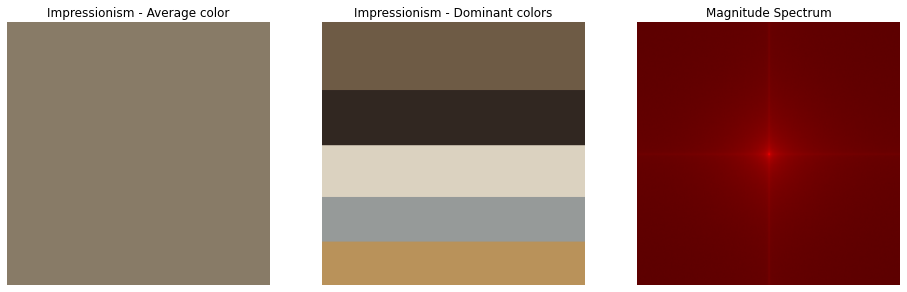

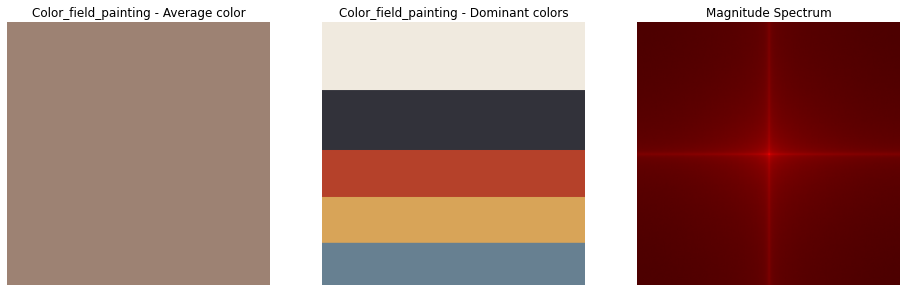

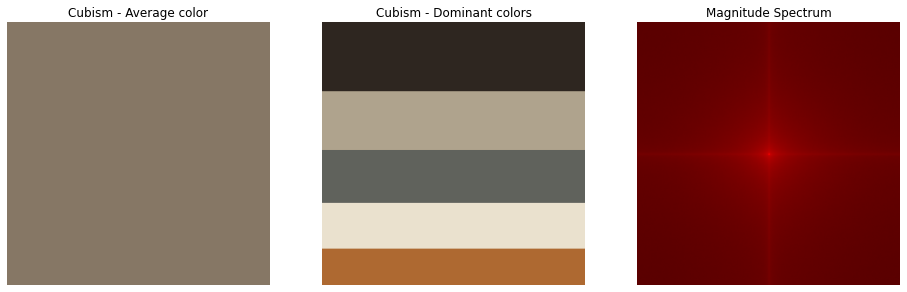

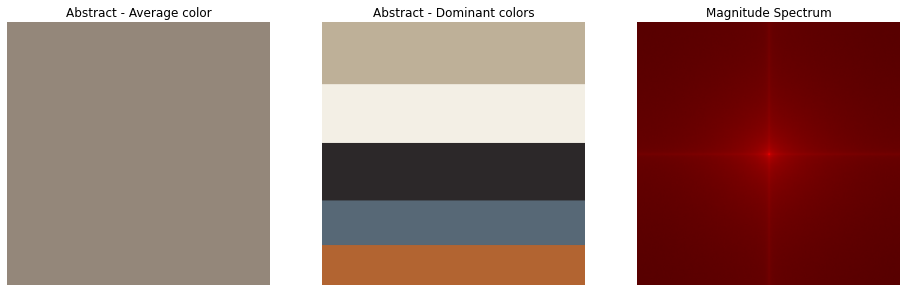

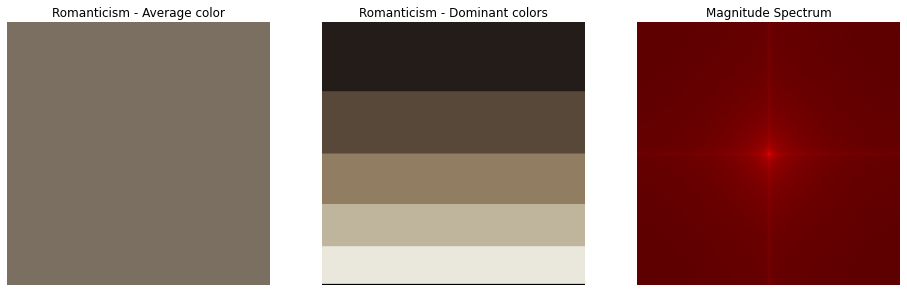

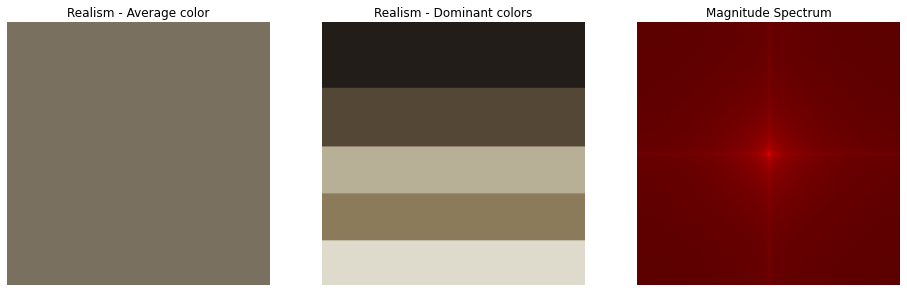

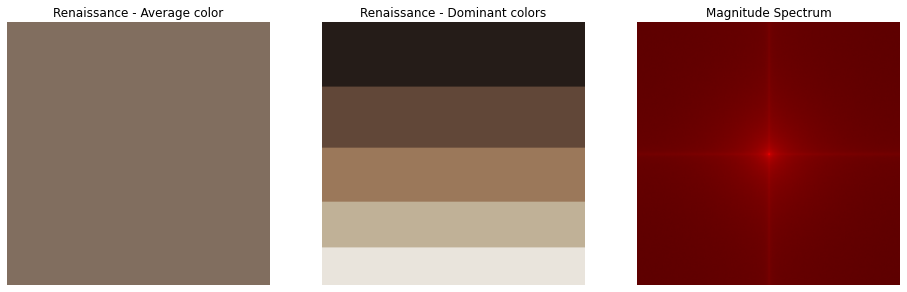

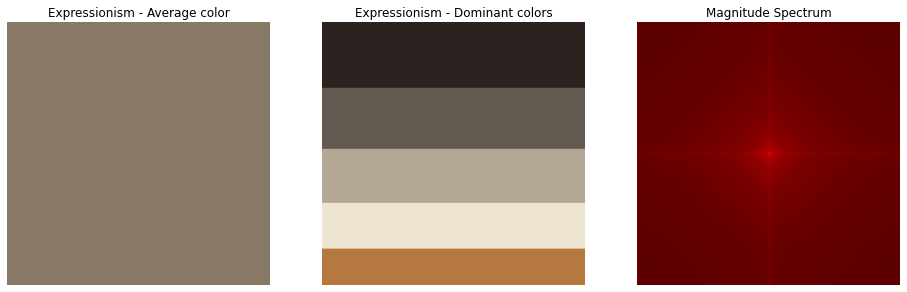

In [101]:
base_dict=baseline_dict(df_train,root,5)


In [103]:
base_dict

{'impressionism': {'avg_color': array([136.63458294, 123.0326014 , 103.62294523]),
  'dom_color': array([[150.2794  , 154.08168 , 153.8472  ],
         [185.00659 , 146.15344 ,  90.28254 ],
         [110.96036 ,  91.97505 ,  69.320076],
         [219.8828  , 210.86957 , 192.1732  ],
         [ 49.0703  ,  39.962715,  33.449505]], dtype=float32),
  'dom_weights': array([0.17251759, 0.1614451 , 0.25914386, 0.19458317, 0.21231029]),
  'mov_fft': array([[[0.34099724, 0.        , 0.        ],
          [0.36794912, 0.        , 0.        ],
          [0.36730999, 0.        , 0.        ],
          ...,
          [0.36653048, 0.        , 0.        ],
          [0.36730999, 0.        , 0.        ],
          [0.36794912, 0.        , 0.        ]],
  
         [[0.36491121, 0.        , 0.        ],
          [0.36695623, 0.        , 0.        ],
          [0.36434097, 0.        , 0.        ],
          ...,
          [0.3680077 , 0.        , 0.        ],
          [0.36499723, 0.        , 0.    

## Compute loss function for average color

In [68]:
y_pred_exp=base_dict['expressionism']['avg_color']
y_pred_cfp=base_dict['color_field_painting']['avg_color']
y=avg_color

print(y,y_pred_exp,y_pred_cfp)


[124.22521655 113.802812    96.20828796] [137.71316895 119.80974515 102.82747795] [145.29177475 121.03592245 106.18640815]


##### quick test

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import math

mse = mean_squared_error(y, y_pred_exp)
mse2 = mean_squared_error(y, y_pred_cfp)

rmse = math.sqrt(mse)
rmse2 = math.sqrt(mse2)

mae = mean_absolute_error(y, y_pred_exp)
mae2 = mean_absolute_error(y, y_pred_cfp)

rsquared = r2_score(y, y_pred_exp)
rsquared2 = r2_score(y, y_pred_cfp)

max_err = max_error(y, y_pred_exp)
max_err2 = max_error(y, y_pred_cfp)

print('Comparison to expressionism')
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
print('Max Error =', round(max_err, 2))
print('\n')
print('Comparison to color field painting')
print('MSE =', round(mse2, 2))
print('RMSE =', round(rmse2, 2))
print('MAE =', round(mae2, 2))
print('R2 =', round(rsquared2, 2))
print('Max Error =', round(max_err2, 2))


Comparison to expressionism
MSE = 87.27
RMSE = 9.34
MAE = 8.7
R2 = 0.35
Max Error = 13.49


Comparison to color field painting
MSE = 198.56
RMSE = 14.09
MAE = 12.76
R2 = -0.49
Max Error = 21.07


In [105]:
base_pred_avg(y,base_dict)

'realism'

##### function

In [106]:
#try on mae :

from sklearn.metrics import mean_absolute_error

y=img1_col['avg_color']

def base_pred_avg(y,base_dict):

    
    mov_list=list(base_dict.keys())

    loss_dict={}     

    for mov in mov_list:
        loss_dict[mov]=mean_absolute_error(y, base_dict[mov]['avg_color'])
        
    return min(loss_dict, key=loss_dict.get)
    

## Compute loss function for dominant color

In [107]:
def base_pred_dom(img,base_dict,n_colors):

    '''
    Description : movement prediction based on dominant colors
    
    '''
    #each color gets compared to dominant colors of every movement
    #rating is done using MAE weighted by the inverse of dominance weights
    #minimal weighted distance is then used as a loss

    mov_list=list(base_dict.keys())

    loss_dict={}

    for mov in mov_list:
        loss_mov=0
        for color_dom in list(range(0,n_colors)):
            loss_list=[]
            for color_mov in list(range(0,n_colors)):
                loss_list.append((base_dict[mov]['dom_weights'][color_mov]*img['dom_weights'][color_dom])**-1 *\
                    mean_absolute_error(img['dom_color'][color_dom]/255,base_dict[mov]['dom_color'][color_mov]/255))
            loss_mov+=min(loss_list)
        loss_dict[mov]=loss_mov    

    return min(loss_dict, key=loss_dict.get)

In [108]:
print(base_pred_dom(img1_col,base_dict,n_colors))
print(base_pred_dom(img2_col,base_dict,n_colors))
print(base_pred_dom(img3_col,base_dict,n_colors))
print(base_pred_dom(img4_col,base_dict,n_colors))
print(base_pred_dom(img5_col,base_dict,n_colors))
print(base_pred_dom(img6_col,base_dict,n_colors))

cubism
impressionism
romanticism
realism
impressionism
color_field_painting


### Check of function prediction on dominant colors images of movements

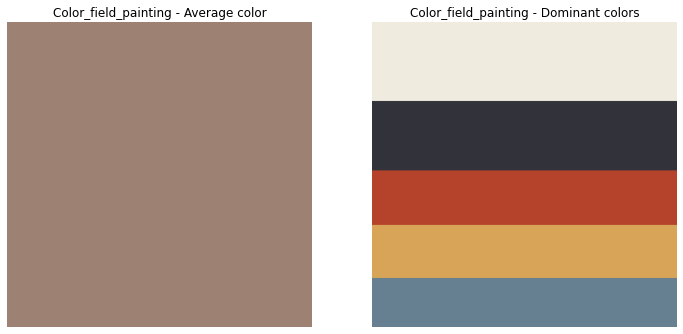

In [109]:
mov='color_field_painting'
n_colors=5
df=df_train
root=MAIN_PATH+IMAGES+'/'


    
path_list=df['file_name'][df['movement']==mov]
pixels=np.empty(3)
for file in list(path_list):
#images are reshaped to 224X224 and pixels are stacked next to each other
    path=root+file
    img=plt.imread(path)
    img_224=np.array(tf.image.resize(img,[224,224]))
    img_pixel = np.float32(img_224.reshape(-1, 3))
    pixels=np.vstack((pixels,img_pixel))

avg_color=pixels.mean(axis=0)


#Recherche palette dominante et couleur dominante par méthode des kmoyens (sur 5 couleurs par défaut)
#premier pixel était là pour initialiser, il faut le virer
pixels=np.float32(pixels)[1:]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, .5)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)
dom_color_cfp = palette[np.argmax(counts)]

    #Viz functions
avg_patch = np.ones(shape=(224,224,3), dtype=np.uint8)*np.uint8(avg_color)

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(224*freqs)

dom_patch_cfp = np.zeros(shape=(224,224,3), dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch_cfp[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title(mov.capitalize()+' - Average color')
ax0.axis('off')
ax1.imshow(dom_patch_cfp)
ax1.set_title(mov.capitalize()+' - Dominant colors')
ax1.axis('off')
plt.show(fig) 

#output selection

plt.show(fig)


weights=counts/pixels.shape[0]
out=None
out =(avg_color,palette,weights)


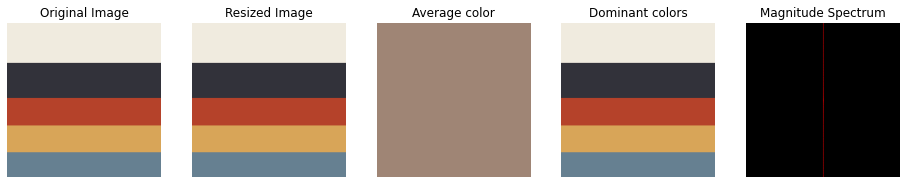

In [110]:
img_cfp=baselines_viz_single(dom_patch_cfp,array=True)

In [111]:
print(base_pred_dom(img_cfp,base_dict,n_colors))

color_field_painting


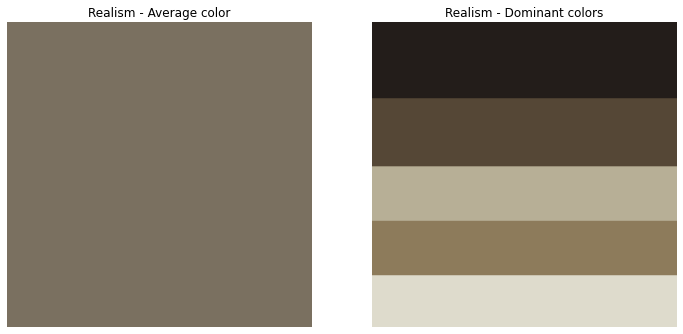

In [112]:
mov='realism'
n_colors=5
df=df_train
root=MAIN_PATH+IMAGES+'/'


    
path_list=df['file_name'][df['movement']==mov]
pixels=np.empty(3)
for file in list(path_list):
#images are reshaped to 224X224 and pixels are stacked next to each other
    path=root+file
    img=plt.imread(path)
    img_224=np.array(tf.image.resize(img,[224,224]))
    img_pixel = np.float32(img_224.reshape(-1, 3))
    pixels=np.vstack((pixels,img_pixel))

avg_color=pixels.mean(axis=0)


#Recherche palette dominante et couleur dominante par méthode des kmoyens (sur 5 couleurs par défaut)
#premier pixel était là pour initialiser, il faut le virer
pixels=np.float32(pixels)[1:]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, .5)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)
dom_color_realism = palette[np.argmax(counts)]

    #Viz functions
avg_patch = np.ones(shape=(224,224,3), dtype=np.uint8)*np.uint8(avg_color)

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(224*freqs)

dom_patch_realism = np.zeros(shape=(224,224,3), dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch_realism[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title(mov.capitalize()+' - Average color')
ax0.axis('off')
ax1.imshow(dom_patch_realism)
ax1.set_title(mov.capitalize()+' - Dominant colors')
ax1.axis('off')
plt.show(fig) 

#output selection

plt.show(fig)


weights=counts/pixels.shape[0]
out=None
out =(avg_color,palette,weights)


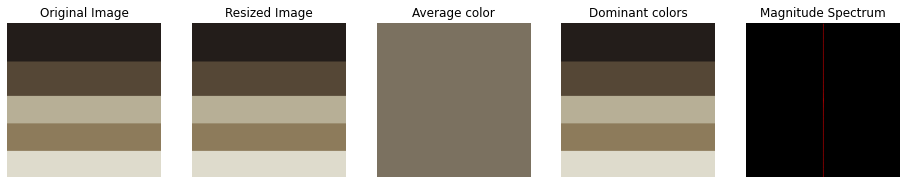

In [113]:
img_realism=baselines_viz_single(dom_patch_realism,array=True)

In [118]:
print(base_pred_dom(img_realism,base_dict,n_colors))

realism


## Compute loss function from Fourier Transformation

##### Check of Fourier Transformation error computation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14499.058120279447

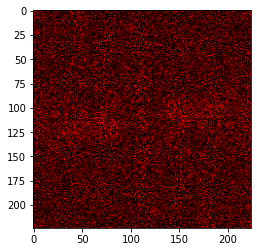

In [119]:
mean_ms=5*np.abs((img3_col['magnitude_spectrum']-img2_col['magnitude_spectrum']))
plt.imshow(mean_ms, cmap = 'gray')

mean_ms.sum()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14301.082688403114

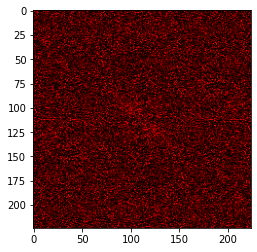

In [120]:
mean_ms=5*np.abs((img6_col['magnitude_spectrum']-img4_col['magnitude_spectrum']))
plt.imshow(mean_ms, cmap = 'gray')
mean_ms.sum()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.0, 1.0, 0.0, 1.0)

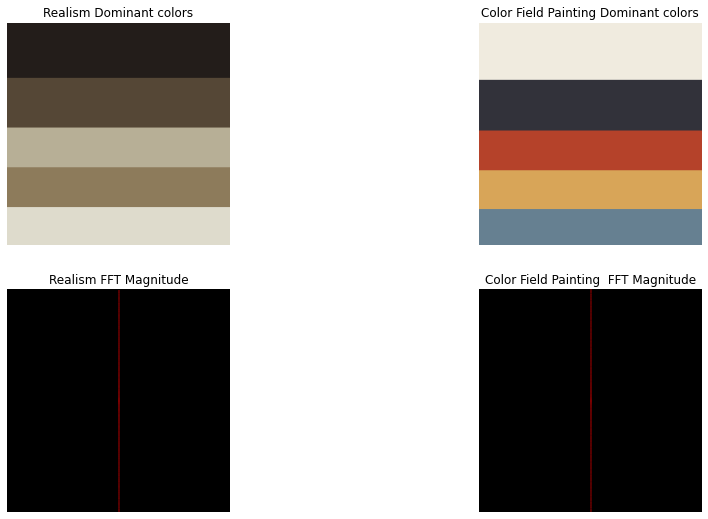

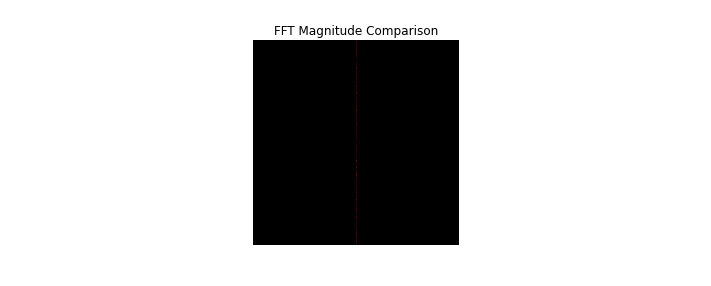

In [121]:
# coeff of 5 seems to be enough to illustrate differences in shapes

mean_ms=5*np.abs((img_realism['magnitude_spectrum']-img_cfp['magnitude_spectrum']))


fig1, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(15.5,9))
ax0.imshow(dom_patch_realism)
ax0.set_title('Realism Dominant colors')
ax0.axis('off')
ax1.imshow(dom_patch_cfp)
ax1.set_title('Color Field Painting Dominant colors')
ax1.axis('off')
ax2.imshow(img_realism['magnitude_spectrum'])
ax2.set_title('Realism FFT Magnitude')
ax2.axis('off')
ax3.imshow(img_cfp['magnitude_spectrum'])
ax3.set_title('Color Field Painting  FFT Magnitude')
ax3.axis('off')

fig2, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12.5,5))
ax0.axis('off')

ax1.imshow(mean_ms, cmap = 'gray')
ax1.set_title('FFT Magnitude Comparison')
ax1.axis('off')

ax2.axis('off')



In [122]:
def base_pred_fft(img,base_dict):
    
    mov_list=list(base_dict.keys())

    loss_dict={}

    for mov in mov_list:
        loss_dict[mov]=5*np.abs(img['magnitude_spectrum']-base_dict[mov]['mov_fft']).sum()
        
    return min(loss_dict, key=loss_dict.get)
    

In [123]:
print(base_pred_fft(img1_col,base_dict))
print(base_pred_fft(img2_col,base_dict))
print(base_pred_fft(img3_col,base_dict))
print(base_pred_fft(img4_col,base_dict))
print(base_pred_fft(img5_col,base_dict))
print(base_pred_fft(img6_col,base_dict))
            

abstract
renaissance
renaissance
renaissance
cubism
renaissance


# Baseline Predictions

In [ ]:
def baseline_eval(df_train)